In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk, string

# HW5
### 1 Word clouds

Let first look at a raw wordcloud:

In [2]:
emails = pd.read_csv('hillary-clinton-emails/Emails.csv')
raw_corpus = '\n'.join(emails['RawText'])

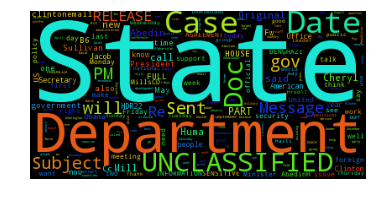

In [3]:
wordcloud = WordCloud().generate(raw_corpus)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Now let create a pipeline (tokenizer, stopwords removal, stemming):

In [4]:
from nltk.corpus import stopwords
# Don't forget to run nltk.download() if not already done...

def tokenize(str):
    return [nltk.word_tokenize(s) for s in nltk.sent_tokenize(str)]

def remove_stopwords(words):
    stopwords = stopwords.words('english')
    return [w for w in words if w.lower() not in stopwords]

def stemming(words):
    porter = nltk.PorterStemmer()
    return [porter.stem(word) for word in words]

def run_pipeline(str, return_as_str=False, do_remove_stopwords=True, do_stemming=True):
    l = []
    words = []
    sentences = tokenize(str)
    for sentence in sentences:
        if do_remove_stopwords:
            words = remove_stopwords(sentence)
        else:
            words = sentence
        if do_stemming:
            words = stemming(words)
        if return_as_str:
            l.append(' '.join(words))
        else:
            l.append(words)
    if return_as_str:
        return ' '.join(l)
    else:
        return l

In [159]:
try:
    stemmed = np.load('stemmed.npy').item()
except:
    stemmed = run_pipeline(raw_corpus, return_as_str=True)
    np.save('stemmed', stemmed)

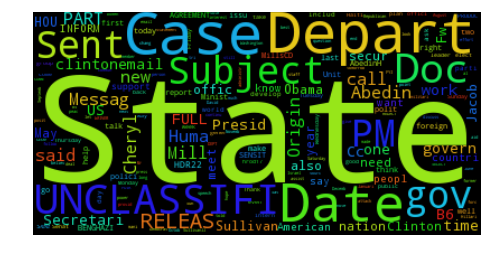

In [160]:
wordcloud_2 = WordCloud().generate(stemmed)
plt.imshow(wordcloud_2)
plt.axis('off')
plt.show()

The two word clouds are very close together.  
The first approach is faster and straightforward but it could lack some fine grained tuning regarding language processing.  
The second one is way slower as we run through many pre-processing steps. But its main advantage is the ability to tune some parameters (stop words, stemming, etc.).

### Part 2

Finding countries in the whole corpus:

__Note:__ We only retrieve countries by their name.  
_When trying with abbreviations we get a lot of false results._

In [170]:
from pycountry import countries

def get_country(str):
    c = None
    '''if (len(country) == 2):
        c = countries.get(alpha_2=country)
    elif (len(country) == 3):
        c = countries.get(alpha_3=country)
    else:
        c = countries.get(name=country.title())'''
    if (len(str) > 3):
        try:
            c = countries.get(name=str.title()).name
        except:
            pass
    return c

def retrieve_countries(emails):
    mentioned = {}
    
    def add(country, i):
        if country in mentioned:
            mentioned[country].append(i)
        else:
            mentioned[country] = [i]
    
    for i, email in emails.iteritems():
        tokens = nltk.word_tokenize(email)
        for token in tokens:
            country = get_country(token)
            if country:
                add(country, i)
    return mentioned

try:
    mentioned = np.load('mentioned.npy').item()
except:
    mentioned = retrieve_countries(emails['RawText'])
    np.save('mentioned.npy', mentioned)

In [171]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

try:
    polarities = np.load('polarities.npy')
except:
    sid = SentimentIntensityAnalyzer()
    polarities = [sid.polarity_scores(email) for email in emails['RawText']]
    np.save('polarities.npy', polarities)

In [172]:
polarities[0]

{'compound': 0.9468, 'neg': 0.099, 'neu': 0.711, 'pos': 0.19}

In [180]:
total = {}
for country, emails in mentioned.items():
    l = []
    for email in set(emails):
        l.append(polarities[email]['compound'])
    total[country] = np.mean(l)
    #total[country] = np.median(sorted(l))
import operator
sorted_total = sorted(total.items(), key=operator.itemgetter(1))

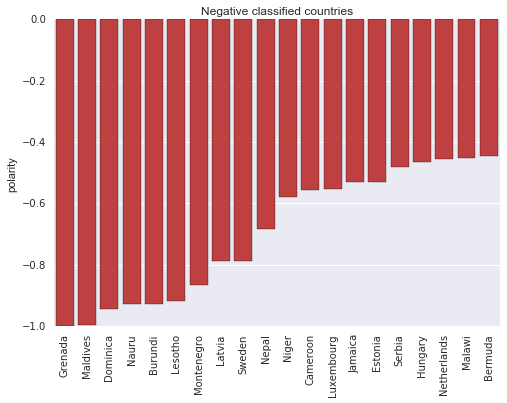

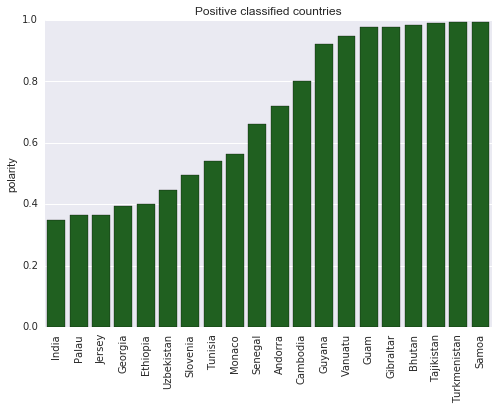

In [181]:
import seaborn as sns

#x = list(sorted_total.keys())
#y = list(sorted_total.values())
sns.barplot(*zip(*sorted_total[:20]), color='red', saturation=.5)
plt.title('Negative classified countries')
plt.ylabel('polarity')
plt.xticks(rotation=90)
plt.show()
sns.barplot(*zip(*sorted_total[-20:]), color='green', saturation=.5)
plt.title('Positive classified countries')
plt.ylabel('polarity')
plt.xticks(rotation=90)
plt.show()

In [52]:
def demo_liu_hu_lexicon(sentence):
    from nltk.corpus import opinion_lexicon
    from nltk.tokenize import treebank

    tokenizer = treebank.TreebankWordTokenizer()
    pos_words = 0
    neg_words = 0
    tokenized_sent = [word.lower() for word in tokenizer.tokenize(sentence)]

    for word in tokenized_sent:
        if word in opinion_lexicon.positive():
            pos_words += 1
        elif word in opinion_lexicon.negative():
            neg_words += 1

    if pos_words > neg_words:
        print('Positive')
    elif pos_words < neg_words:
        print('Negative')
    elif pos_words == neg_words:
        print('Neutral')


str = "This movie was actually neither that funny, nor super witty."

demo_liu_hu_lexicon(str)
#demo_vader_instance(str)
#sid = SentimentIntensityAnalyzer()
#sid.polarity_scores(str)#['compound']
#sentiments = [map(sid.polarity_scores, t) for t in emails['RawText']]

Positive


### Part 3

Exploring the topics:

In [ ]:
from gensim import models.ldamodel
dictionary = corpora.Dictionary(raw_corpus)
corpus = dictionary.doc2bow(raw_corpus)
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=50, id2word = dictionary)
lda = LdaModel(corpus, num_topics=50) # 5 to 50